In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", 
    infer_datetime_format=True, parse_dates=True)

yen_futures

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

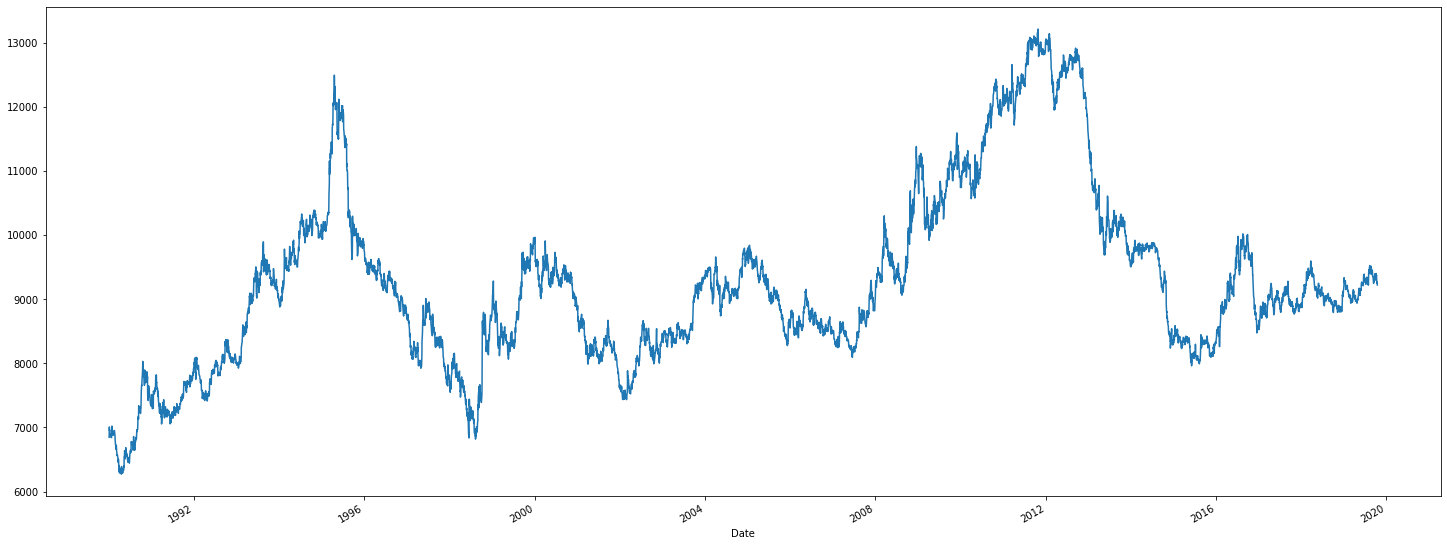

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize = (25,10))

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise. The Hodrick–Prescott filter (also known as Hodrick–Prescott decomposition) is a mathematical tool used in macroeconomics, especially in real business cycle theory, to remove the cyclical component of a time series from raw data. It is used to obtain a smoothed-curve representation of a time series, one that is more sensitive to long-term than to short-term fluctuations. The adjustment of the sensitivity of the trend to short-term fluctuations is achieved by modifying a multiplier {\displaystyle \lambda }\lambda .

In [5]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
data_df = pd.DataFrame(yen_futures, columns = ['Settle'])
data_df['Noise'] = ts_noise
data_df['Trend'] = ts_trend

data_df

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062
...,...,...,...
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594


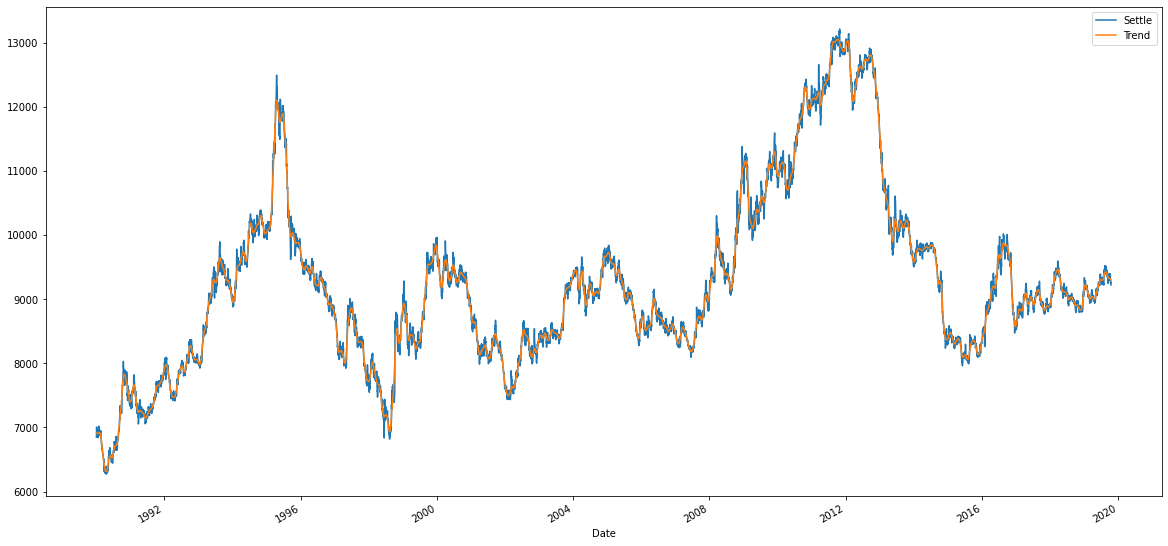

In [7]:
# Plot the Settle Price vs. the Trend
data_df.iloc[:,[0,2]].plot(figsize = (20,10))

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

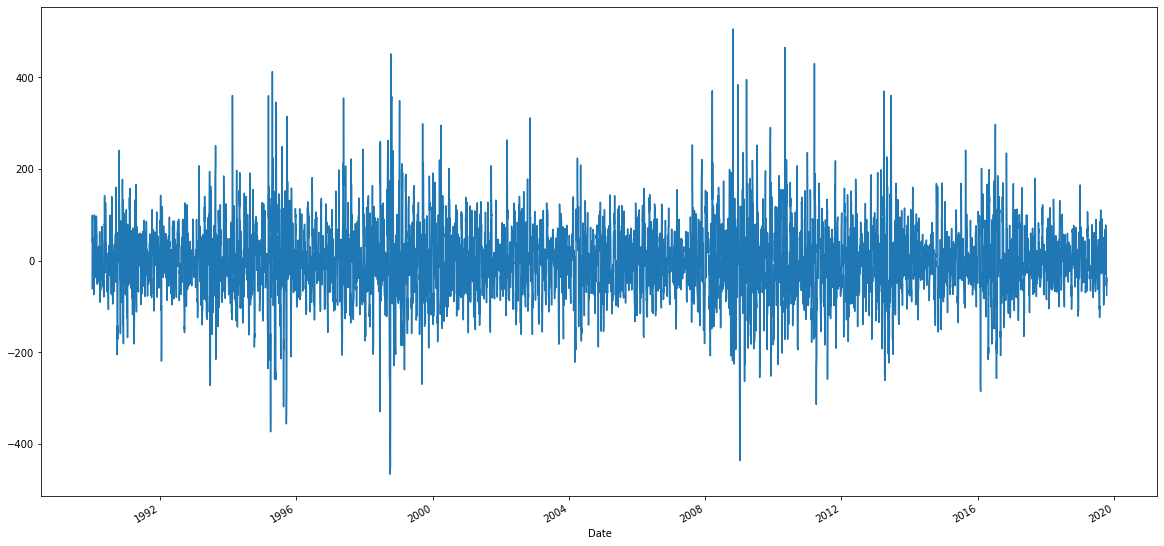

In [8]:
# Plot the Settle Noise
ts_noise.plot(figsize=(20,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

ARMA model is simply the merger between AR(p) and MA(q) models:

- AR(p) models try to explain the momentum and mean reversion effects often observed in trading markets (market participant effects).

- MA(q) models try to capture the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, wars, attacks, etc.

ARMA model attempts to capture both of these aspects when modelling financial time series. ARMA model does not take into account volatility clustering, a key empirical phenomena of many financial time series

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.Settle, order=(2,1))

# Fit the model and assign it to a variable called results
ARMA_results = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [11]:
# Output model summary results:
ARMA_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 11 Mar 2020   AIC                          15798.142
Time:                        22:15:54   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.Settle    -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.278      0.231      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.1918           +0.0000j          157.1918            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

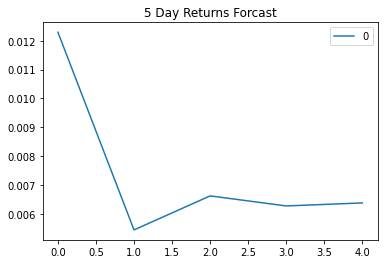

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(ARMA_results.forecast(steps=5)[0]).plot(title="5 Day Returns Forcast")

Question: Based on the p-value, is the model a good fit?

Answer:

THe model does not seem to be a good fit based on p-value.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

Autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.[1]

The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values. The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). The purpose of each of these features is to make the model fit the data as well as possible.

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model.

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
ARIMA_model = ARIMA(data_df['Settle'], order=(5, 1, 1))
# Fit the model
ARIMA_results = ARIMA_model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
ARIMA_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 11 Mar 2020   AIC                          83905.238
Time:                        22:15:59   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2823      0.699      0.404      0.686      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3786j            2.3409           -0.1002
AR.2            1.8920           +1.3786j            2.3409            0.1002
AR.3           -2.2711           -3.0199j            3.7785           -0.3526
AR.4           -2.2711           +3.0199j            3.7785            0.3526
AR.5          -11.1033           -0.0000j           11.1033           -0.5000
MA.1            3.3632           +0.0000j            3.3632            0.0000
-----------------------------------------------------------------------------
"""

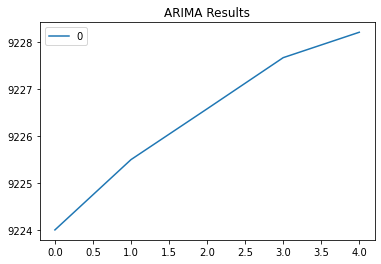

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(ARIMA_results.forecast(steps=5)[0]).plot(title="ARIMA Results")

What does the model forecast will happen to the Japanese Yen in the near term?

The model forecasts that the price of the Yen will continue its trend and appcreciate in the future. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch

In [17]:
daily_returns = data_df.pct_change()

In [21]:
# Estimate a GARCH model:
Garch_model = arch.arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)
# Fit the model
Garch_results = Garch_model.fit(disp="off")

In [23]:
# Summarize the model results
Garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Wed, Mar 11 2020   Df Residuals:                     7510
Time:                        22:16:50   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [24]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [26]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecast = Garch_results.forecast(start = '2019-10-15', horizon = forecast_horizon)

In [28]:
# Annualize the forecast
intermediate = np.sqrt(forecast.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [29]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


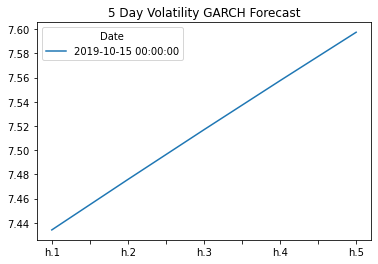

In [30]:
# Plot the final forecast
final.plot(title='5 Day Volatility GARCH Forecast')


---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?